# Model Optimisations

## Import Libraries

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from inspect import signature
from itertools import cycle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, make_scorer, roc_curve, classification_report, precision_recall_curve

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE



## Gridsearch best estimators and parameters 

In [4]:
#code found from http://www.davidsbatista.net/blog/2018/02/23/model_optimization/
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=-1, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]


In [68]:
classifier_model_params = {
    'LogisticRegression' : {
        'penalty' : ['l1', 'l2'],
        'C' : np.arange(.05, 1, .05) },
    'VanillaLogRegression' : {
    },
    'KNN' : {
        'n_neighbors' : np.arange(3, 22, 2) },
    'NaiveBayes' : {
        'alpha' : np.arange(.05, 2, .05)},
    'DecisionTree': {
        'max_depth' : [None, 6, 10, 14], 
        'min_samples_leaf' : [1, 2],
        'min_samples_split': [2, 3] },
    'BaggedDecisionTree' : {
        'n_estimators' : [20, 60, 100] },
    'RandomForest' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 2, 6, 10],
        'min_samples_split' : [2, 3, 4] },
    'ExtraTrees' : {
        'n_estimators' : [20, 60, 100],
        'max_depth' : [None, 6, 10, 14],
        'min_samples_leaf' : [1, 2], 
        'min_samples_split' : [2, 3], },
    'AdaBoost' : {
        'n_estimators' : np.arange(100, 151, 25),
        'learning_rate' : np.linspace(0.05, 1, 10) },
    'GradientBoosting' : {
        'n_estimators' : np.arange(5, 150, 15),
        'learning_rate' : np.linspace(0.05, 1, 10),
        'max_depth' : [1, 2, 3] },
    'SVM' : {
        'C' : np.arange(0.05, 1, .05),
        'kernel' : ['rbf', 'linear'] },
     'XGBoost' : {
        'n_estimators'  : np.arange(100, 151, 25), 
        'learning_rate' : np.arange(0.1, 1, .3),
        'max_depth' : [3],
        'alpha' : np.arange(0, 1, .3),
        'lambda' : np.arange(0, 1, .3),
        'gamma' : np.arange(0, 1, .3),
        'subsample' : [.5],
        'n_jobs' : [4],}
        }

In [8]:
scaler = StandardScaler()
sm = SMOTE(sampling_strategy=1,random_state=666)

train = pd.read_csv('./data/train_weather.csv')
train_dummies = pd.get_dummies(train,drop_first=True,columns=['Species','Street'])
y = train_dummies['WnvPresent']
X = train_dummies[[col for col in train_dummies.columns if col != 'WnvPresent']]

train_x, test_x, train_y, test_y = train_test_split(X,y,test_size = 0.3, random_state = 666,stratify=y)
train_x=scaler.fit_transform(train_x)
test_x=scaler.transform(test_x)
sampledX,sampledy = sm.fit_sample(train_x,train_y)

In [70]:
classifier_models = {
    'LogisticRegression' : LogisticRegression(random_state = 42),
    'VanillaLogRegression' : LogisticRegression(random_state = 42),
    'KNN': KNeighborsClassifier(), 
#     'NaiveBayes' : MultinomialNB(), #does not work with negative vals
#     'DecisionTree' : DecisionTreeClassifier(random_state = 42), 
#     'BaggedDecisionTree' : BaggingClassifier(random_state = 42),
#     'RandomForest' : RandomForestClassifier(random_state = 42), 
#     'ExtraTrees' : ExtraTreesClassifier(random_state = 42), 
#     'AdaBoost' : AdaBoostClassifier(random_state=42), 
#     'GradientBoosting' : GradientBoostingClassifier(random_state = 42),
#     'SVM' : SVC(random_state=42),
#     'XGBoost' : XGBClassifier(random_state=42)
}

In [71]:
rec=make_scorer(recall_score,average='binary',pos_label=1)
search = EstimatorSelectionHelper(classifier_models, classifier_model_params)
search.fit(sampledX,sampledy, scoring=rec, n_jobs=3)

Running GridSearchCV for LogisticRegression.
Fitting 3 folds for each of 38 candidates, totalling 114 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:   57.9s
[Parallel(n_jobs=3)]: Done 114 out of 114 | elapsed:  2.6min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for VanillaLogRegression.
Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


Running GridSearchCV for KNN.
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed:  5.7min finished


We then score our different models and output our results to a csv for archival.

In [73]:
score1=search.score_summary(sort_by='mean_score')

LogisticRegression
VanillaLogRegression
KNN


C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [76]:
score1=pd.read_csv(r'.\data\score3.csv')

In [17]:
score1=pd.concat([score1,score2])

C:\Users\chang\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [18]:
score1.to_csv(r'.\data\score3.csv',index=False)

In [79]:
score1=score1.sort_values('mean_score',ascending=False)

In [81]:
scores = score1[score1['mean_score'] == score1.groupby('estimator')['mean_score'].transform('max')]

In [83]:
scores.groupby('estimator').head(1)

,C,alpha,estimator,gamma,kernel,lambda,learning_rate,max_depth,max_score,mean_score,min_samples_leaf,min_samples_split,min_score,n_estimators,n_jobs,n_neighbors,penalty,std_score,subsample
13,NaN,NaN,ExtraTrees,NaN,NaN,NaN,NaN,NaN,0.991387,0.984927,2.0,2.0,0.972868,60.0,NaN,NaN,NaN,0.008534,NaN
25,NaN,NaN,RandomForest,NaN,NaN,NaN,NaN,10.0,0.986219,0.971433,NaN,3.0,0.945306,100.0,NaN,NaN,NaN,0.018528,NaN
28,NaN,NaN,DecisionTree,NaN,NaN,NaN,NaN,14.0,0.985788,0.959231,1.0,2.0,0.921189,NaN,NaN,NaN,NaN,0.027595,NaN
14,NaN,NaN,BaggedDecisionTree,NaN,NaN,NaN,NaN,NaN,0.991387,0.957221,NaN,NaN,0.894057,100.0,NaN,NaN,NaN,0.044713,NaN
470,NaN,0.0,XGBoost,0.3,NaN,0.9,0.400000,3.0,0.988372,0.951766,NaN,NaN,0.879845,150.0,4.0,NaN,NaN,0.050858,0.5
824,NaN,NaN,GradientBoosting,NaN,NaN,NaN,0.261111,3.0,0.987080,0.949038,NaN,NaN,0.875538,140.0,NaN,NaN,NaN,0.051983,NaN
64,NaN,NaN,KNN,NaN,NaN,NaN,NaN,NaN,0.955642,0.942578,NaN,NaN,0.920758,NaN,NaN,3.0,NaN,0.015529,NaN
153,NaN,NaN,AdaBoost,NaN,NaN,NaN,0.788889,NaN,0.964255,0.931668,NaN,NaN,0.867356,150.0,NaN,NaN,NaN,0.045477,NaN
172,0.90,NaN,SVM,NaN,rbf,NaN,NaN,NaN,0.941860,0.923629,NaN,NaN,0.890612,NaN,NaN,NaN,NaN,0.023389,NaN
135,0.15,NaN,LogisticRegression,NaN,NaN,NaN,NaN,NaN,0.860465,0.855154,NaN,NaN,0.851852,NaN,NaN,NaN,l2,0.003793,NaN


In [29]:
estimators = {
    'XGB' : XGBClassifier(random_state = 42, gamma=0.3,learning_rate=0.4,max_depth=3,n_estimators=150,subsample=0.5),
    'ADA' : AdaBoostClassifier(random_state = 42,learning_rate=0.788889,n_estimators=150),
    'GBoost' : GradientBoostingClassifier(random_state = 42,learning_rate=0.261111,max_depth=3,n_estimators=140),
    'SVC' : SVC(random_state = 42,kernel='rbf',probability=True),
    'DecisionTree' : DecisionTreeClassifier(random_state = 42,max_depth=None,min_samples_leaf=1,min_samples_split=2),
    'knn' : KNeighborsClassifier(n_neighbors=3),
    'random forest' : RandomForestClassifier(random_state = 42,max_depth=10,min_samples_split=2,n_estimators=100),
    'ef' : ExtraTreesClassifier(random_state = 42,min_samples_leaf=2,min_samples_split=2,n_estimators=60),
    'lr with reg' : LogisticRegression(random_state = 42,penalty='l2',C=0.05),
    'bagging classifier' : BaggingClassifier(random_state = 42,n_estimators=100),
    'vanilla logistic regression' : LogisticRegression(random_state=42)
}

In [58]:
scores = []

In [59]:
for e_name,estimator in estimators.items():
    estimator.fit(sampledX,sampledy)
    pred=estimator.predict(test_x)
    fpr, tpr, _ = roc_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    precision, recall, _ = precision_recall_curve(test_y, estimator.predict_proba(test_x)[:,1],pos_label=1)
    score = {'est':e_name,
             'roc_curve':[fpr, tpr],
             'prc':[precision,recall]}
    scores.append(score)
    print('Results for ',e_name,':')
    print(classification_report(test_y,pred))


Results for  XGB :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2987
           1       0.28      0.25      0.26       165

    accuracy                           0.93      3152
   macro avg       0.62      0.61      0.61      3152
weighted avg       0.92      0.93      0.93      3152

Results for  ADA :
              precision    recall  f1-score   support

           0       0.97      0.91      0.94      2987
           1       0.24      0.50      0.32       165

    accuracy                           0.89      3152
   macro avg       0.60      0.70      0.63      3152
weighted avg       0.93      0.89      0.91      3152

Results for  GBoost :
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2987
           1       0.28      0.31      0.29       165

    accuracy                           0.92      3152
   macro avg       0.62      0.63      0.63      3152
weighted avg  

/Users/syamil/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Results for  SVC :
              precision    recall  f1-score   support

           0       0.97      0.84      0.90      2987
           1       0.16      0.53      0.24       165

    accuracy                           0.83      3152
   macro avg       0.56      0.68      0.57      3152
weighted avg       0.93      0.83      0.87      3152

Results for  DecisionTree :
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      2987
           1       0.20      0.27      0.23       165

    accuracy                           0.91      3152
   macro avg       0.58      0.61      0.59      3152
weighted avg       0.92      0.91      0.91      3152

Results for  knn :
              precision    recall  f1-score   support

           0       0.96      0.89      0.92      2987
           1       0.14      0.32      0.19       165

    accuracy                           0.86      3152
   macro avg       0.55      0.60      0.56      3152
weighted

/Users/syamil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  lr with reg :
              precision    recall  f1-score   support

           0       0.98      0.78      0.87      2987
           1       0.15      0.67      0.24       165

    accuracy                           0.78      3152
   macro avg       0.56      0.73      0.55      3152
weighted avg       0.93      0.78      0.84      3152

Results for  bagging classifier :
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2987
           1       0.21      0.22      0.21       165

    accuracy                           0.92      3152
   macro avg       0.58      0.59      0.58      3152
weighted avg       0.92      0.92      0.92      3152



/Users/syamil/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Results for  vanilla logistic regression :
              precision    recall  f1-score   support

           0       0.98      0.79      0.87      2987
           1       0.15      0.65      0.24       165

    accuracy                           0.78      3152
   macro avg       0.56      0.72      0.56      3152
weighted avg       0.93      0.78      0.84      3152



In [ ]:
{'est':e_name,
             'roc_curve':[fpr, tpr],
             'prc':[precision,recall]}

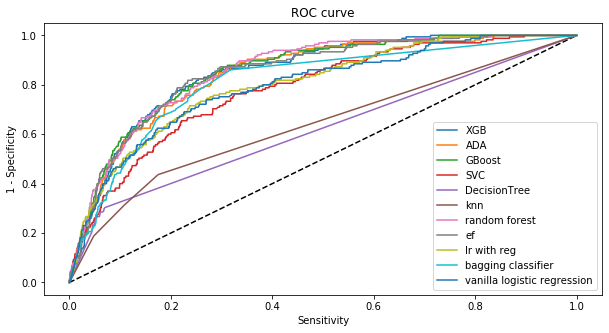

In [62]:
#### Plot figure
plt.figure(1,figsize=(10,5))
plt.plot([0, 1], [0, 1], 'k--')
for score in scores:
    plt.plot(score['roc_curve'][0], score['roc_curve'][1], label=score['est'])
plt.xlabel('Sensitivity')
plt.ylabel('1 - Specificity')
plt.title('ROC curve')
plt.legend(loc='best')

plt.show()

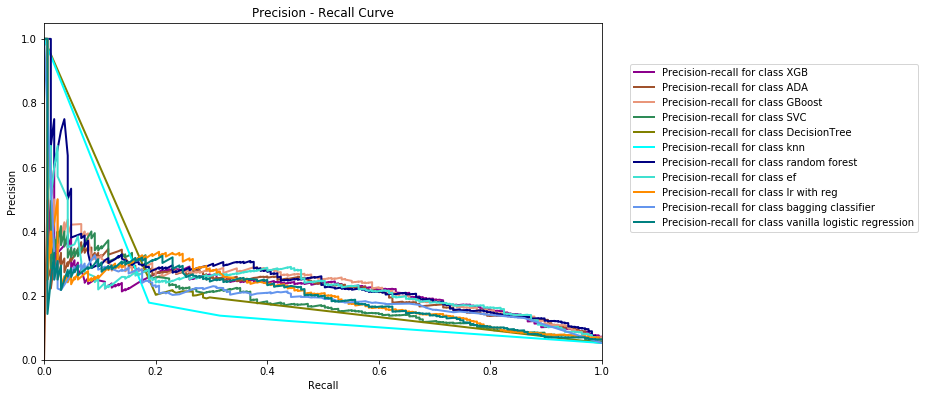

In [84]:
colors = ['darkmagenta','sienna','darksalmon',
          'seagreen','olive','cyan','navy', 
          'turquoise', 'darkorange', 'cornflowerblue', 'teal']

plt.figure(figsize=(10, 6))
lines = []
labels = []
idx=0
for score in scores:
    l, = plt.plot(score['prc'][1], score['prc'][0], color=colors[idx], lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0}'.format(score['est']))
    idx+=1
    
fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision - Recall Curve')
plt.legend(lines, labels, loc=(1.05, .38), prop=dict(size=10))


plt.show()
